In [1]:
# %matplotlib widget

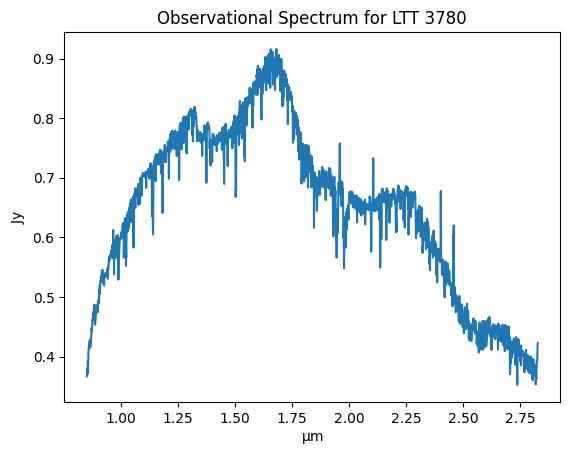

[SPECTRUM COMPONENT ANALYSER] : reading in hdf5
[SPECTRUM COMPONENT ANALYSER] : finished reading in hdf5


In [2]:
from itertools import product
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.units import Quantity
quantity_support()
from tqdm import tqdm
import astropy.units as u
import os

from spectrum_component_analyser.internals.spectrum import spectrum
from spectrum_component_analyser.internals.readers import read_JWST_fits,read_JWST_fits_all_spectra
from spectrum_component_analyser.internals.spectral_grid import spectral_grid
from spectrum_component_analyser.helper import calc_fitted_spectrum, get_optimality, plot_nicely, get_main_components

star_name : str = "LTT 3780"
star_temperature : Quantity[u.K] = 3350 * u.K

script_dir = os.getcwd()
jwst_file_segment_001 = (script_dir / Path("../../observed_spectra/MAST_2025-10-26T11_57_04.058Z - LTT-3780/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")).resolve()
jwst_file_segment_002 = (script_dir / Path("../../observed_spectra/MAST_2025-10-26T11_57_04.058Z - LTT-3780/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg002_nis_x1dints.fits")).resolve()
jwst_file_segment_003 = (script_dir / Path("../../observed_spectra/MAST_2025-10-26T11_57_04.058Z - LTT-3780/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg003_nis_x1dints.fits")).resolve()
jwst_file_segment_004 = (script_dir / Path("../../observed_spectra/MAST_2025-10-26T11_57_04.058Z - LTT-3780/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg004_nis_x1dints.fits")).resolve()

spectrum_to_decompose : spectrum = read_JWST_fits(jwst_file_segment_001, INTEGRATION_INDEX=100, name=star_name, T_eff = star_temperature)

mask = np.isfinite(spectrum_to_decompose.Fluxes) # & (spectrum_to_decompose.Wavelengths < 1.8 * u.um)

spectrum_to_decompose = spectrum_to_decompose[mask]

spectrum_to_decompose.plot()

print("[SPECTRUM COMPONENT ANALYSER] : reading in hdf5")
# spectral_grid_relative_path = Path("../../spectral_grids/JWST_convolved_spectral_grid.hdf5")
spectral_grid_relative_path = Path("../../spectral_grids/JWST_convolved_not_oversmoothed.hdf5")
spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
spec_grid : spectral_grid = spectral_grid.from_hdf5(absolute_path=spectral_grid_absolute_path)
lookup_table = spec_grid.to_lookup_table()
print("[SPECTRUM COMPONENT ANALYSER] : finished reading in hdf5")

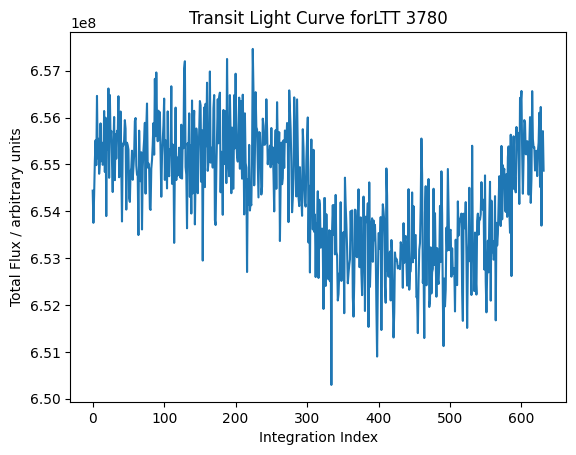

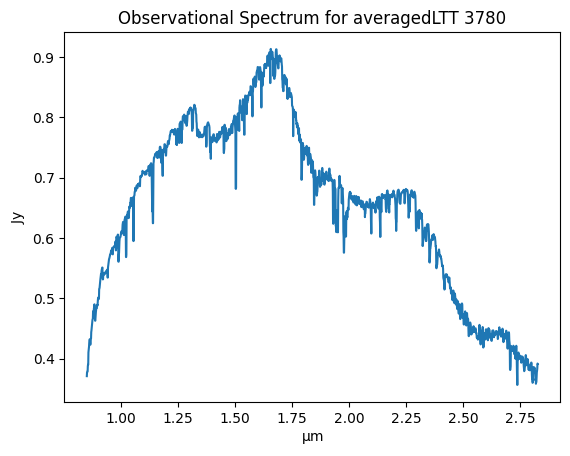

In [3]:
# lets analyse the JWST fits file: lets make a transmission curve
from scipy.signal import medfilt

from spectrum_component_analyser.internals.readers import JWST_NORMALISING_POINT

all_segments = [jwst_file_segment_001, jwst_file_segment_002, jwst_file_segment_003, jwst_file_segment_004]

all_spectra = []

for segment in all_segments:
    all_spectra.extend(read_JWST_fits_all_spectra(segment, T_eff = None, name=star_name))

total_fluxes = []
for spec in all_spectra:
    # this looks to remove quite a lot of information
    spec.Wavelengths = spec.Wavelengths[mask]
    spec.Fluxes = medfilt(spec.Fluxes[mask], kernel_size=3) * spec.Fluxes.unit
    total_fluxes.append(np.sum(spec.Fluxes).value)

    # less harsh option
    # total_fluxes.append(np.sum(spec.Fluxes[mask]).value)

plt.clf()
plt.plot([i for i in range(len(total_fluxes))], total_fluxes)
plt.xlabel("Integration Index")
plt.ylabel("Total Flux / arbitrary units")
plt.title("Transit Light Curve for" + star_name)
plt.show()

min_included_integration_index = 0
max_included_integration_index = 300

all_fluxes=[spec.Fluxes for spec in all_spectra[min_included_integration_index:max_included_integration_index]]

spectrum_to_decompose = spectrum(wavelengths=all_spectra[0].Wavelengths,
                                 fluxes=np.mean(all_fluxes, axis=0) * all_fluxes[0].unit,
                                 normalised_point=JWST_NORMALISING_POINT,
                                 temperature = star_temperature,
                                 observational_resolution=None,
                                 observational_wavelengths=None,
                                 name="averaged" + star_name)

# spectrum_to_decompose = spectrum_to_decompose[mask]

spectrum_to_decompose.plot()

In [4]:
all_parameters = list(product(spec_grid.T_effs, [0, 1] * u.dimensionless_unscaled, [4.5, 5] * u.dimensionless_unscaled))
# all_parameters = list(product(spec_grid.T_effs, [0 * u.dimensionless_unscaled], spec_grid.Log_gs))
# all_parameters = list(product(spec_grid.T_effs, spec_grid.FeHs, [5 * u.dimensionless_unscaled]))
# all_parameters = list(product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.Log_gs))
total_number_of_components = len(all_parameters)

A, result = calc_fitted_spectrum(all_parameters,
                                 lookup_table,
                                 spec_grid=spec_grid,
                                 spectrum_to_decompose=spectrum_to_decompose,
                                 mask=mask,
                                 total_number_of_components=total_number_of_components,
                                 max_iterations=1000)

print(f"residual MSE, residual sum of squares = {get_optimality(A, result, spectrum_to_decompose)}")

Appending values to A matrix...: 100%|██████████| 72/72 [00:00<00:00, 1525.39it/s]


minimising
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         3.5252e+07                                    4.07e+06    
       1         8.7815e+06      2.65e+07       1.67e+01       1.02e+06    
       2         2.1797e+06      6.60e+06       8.34e+00       2.54e+05    
       3         5.3717e+05      1.64e+06       4.17e+00       6.35e+04    
       4         1.3048e+05      4.07e+05       2.09e+00       1.59e+04    
       5         3.0785e+04      9.97e+04       1.04e+00       3.97e+03    
       6         6.8441e+03      2.39e+04       5.20e-01       9.88e+02    
       7         1.3456e+03      5.50e+03       2.59e-01       2.44e+02    
       8         2.0425e+02      1.14e+03       1.26e-01       5.79e+01    
       9         1.8963e+01      1.85e+02       5.70e-02       1.18e+01    
      10         2.7169e+00      1.62e+01       2.01e-02       1.54e+00    
      11         2.1089e+00      6.08e-01       1.33e-02       5.31e+06    
 

        Teff [Fe/H] logg  proportional weight  weight
69  4000.0 K    0.0  5.0                0.574   0.384
35  3100.0 K    1.0  5.0                0.351   0.235
1   2300.0 K    0.0  5.0                0.040   0.027
49  3500.0 K    0.0  5.0                0.034   0.023
45  3400.0 K    0.0  5.0                0.000   0.000
57  3700.0 K    0.0  5.0                0.000   0.000
61  3800.0 K    0.0  5.0                0.000   0.000
71  4000.0 K    1.0  5.0                0.000   0.000
43  3300.0 K    1.0  5.0                0.000   0.000
41  3300.0 K    0.0  5.0                0.000   0.000


/home/bengreen/University/Part III/stellar-heterogeneity-modelling/src/spectrum_component_analyser/helper.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


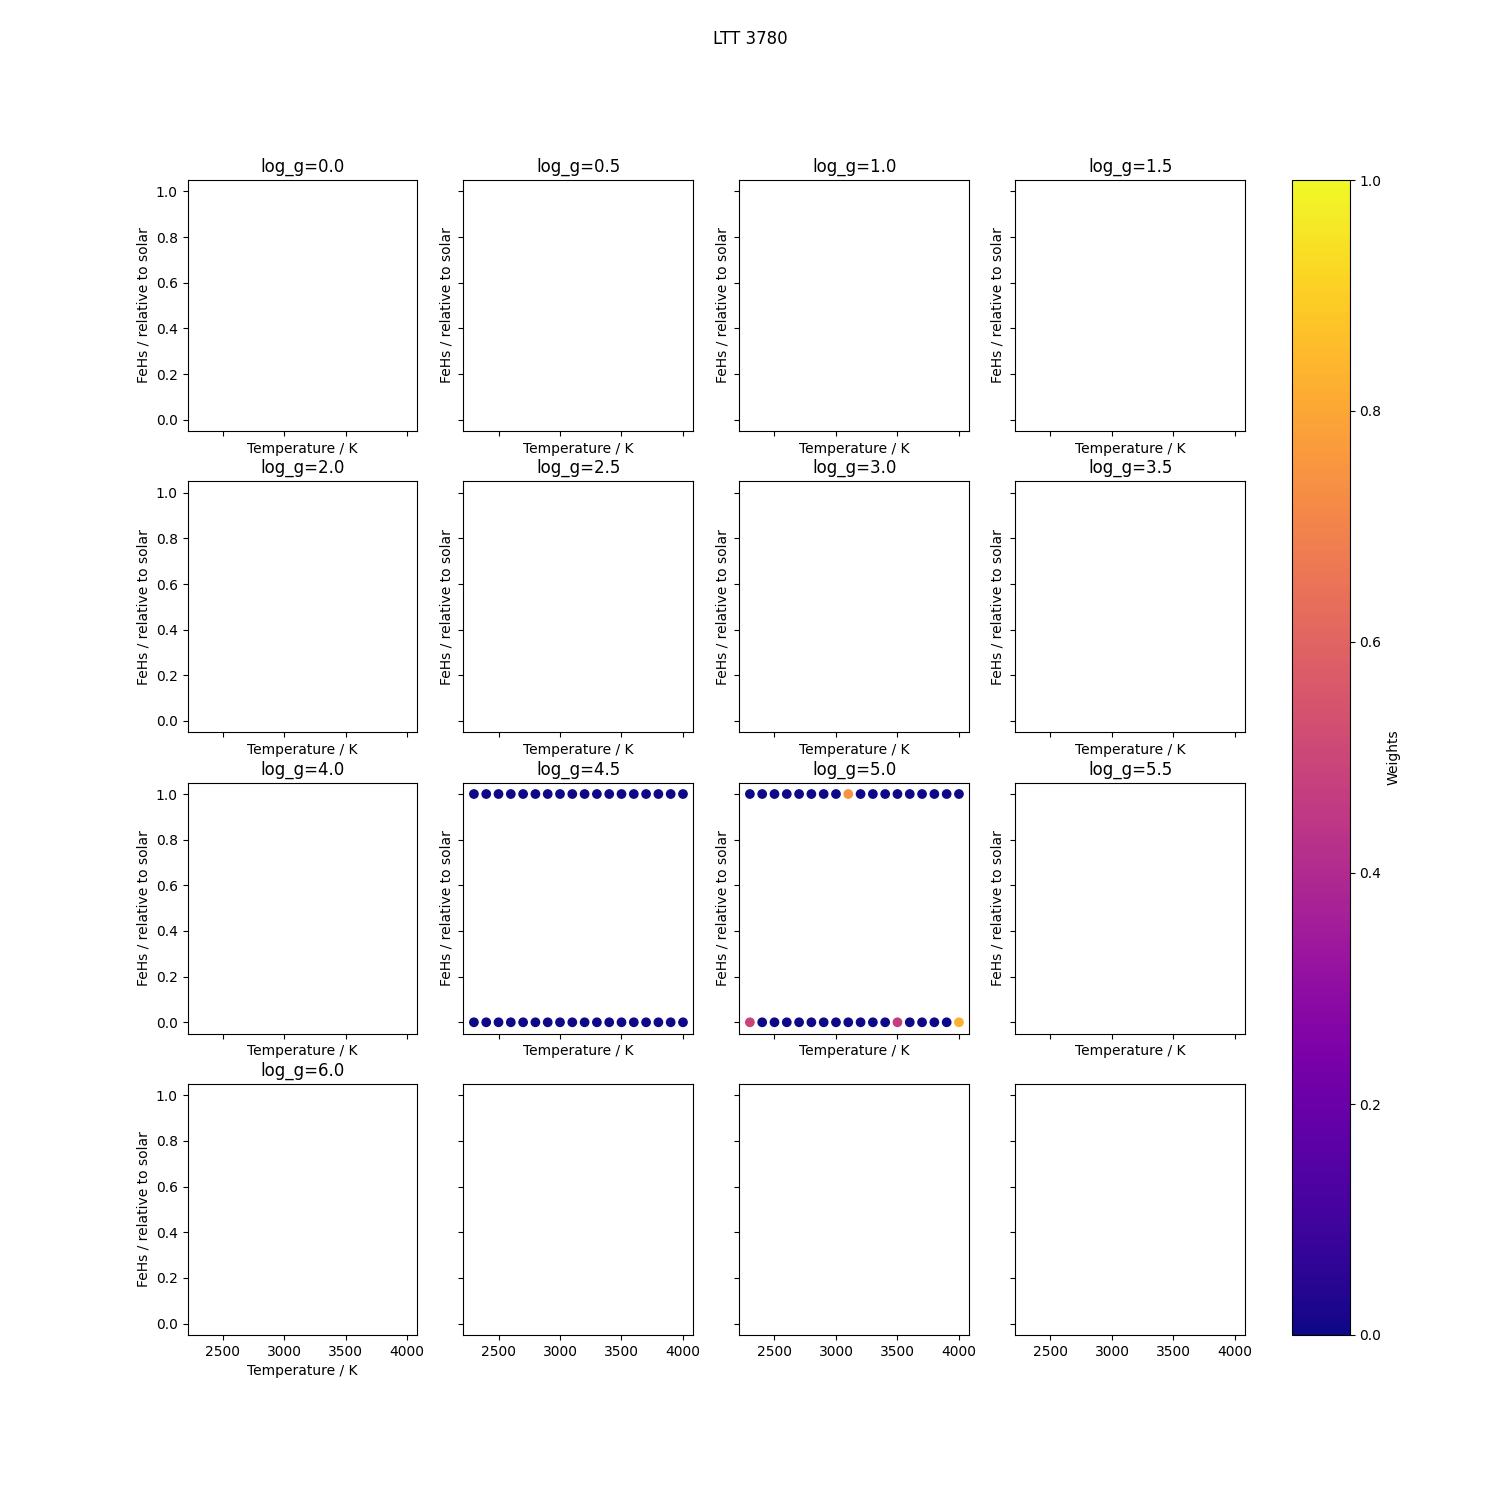

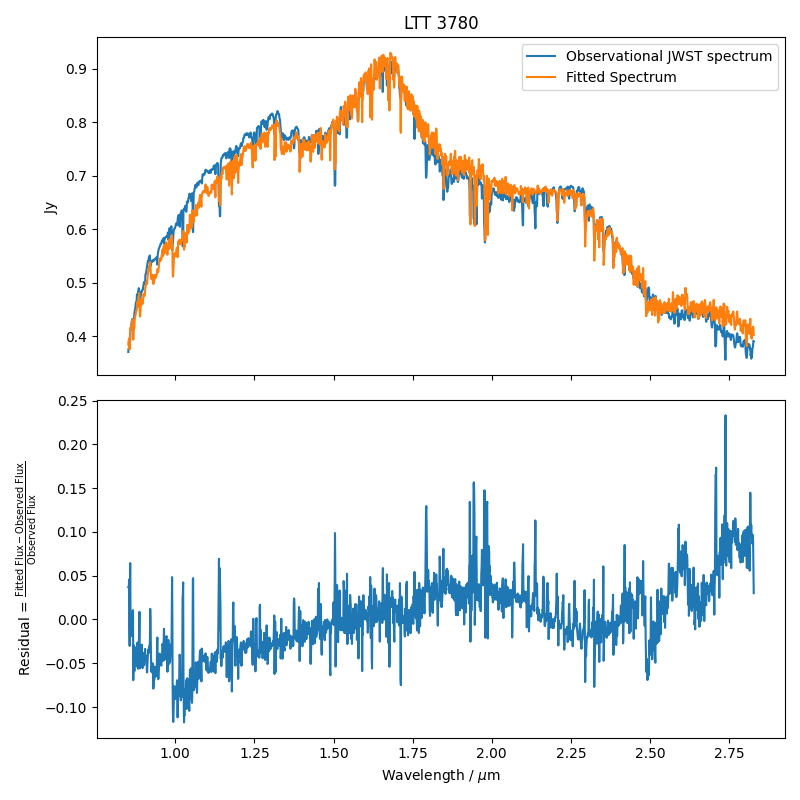

T_eff avg = 3598.180796347496 K
FeH avg = 0.35146602814745037
log g avg = 5.0


In [5]:
%matplotlib widget

from spectrum_component_analyser.helper import FEH_COLUMN, LOGG_COLUMN, TEFF_COLUMN, WEIGHT_COLUMN

hash_map = plot_nicely(A, result, all_parameters, spec_grid, spectrum_to_decompose, star_name)

weights = hash_map[WEIGHT_COLUMN].values

teff_avg = np.average(hash_map[TEFF_COLUMN], weights=weights)
feh_avg  = np.average(hash_map[FEH_COLUMN],  weights=weights)
logg_avg = np.average(hash_map[LOGG_COLUMN], weights=weights)

print(f"T_eff avg = {teff_avg}")
print(f"FeH avg = {feh_avg}")
print(f"log g avg = {logg_avg}")

100%|██████████| 19/19 [00:00<00:00, 51.51it/s]


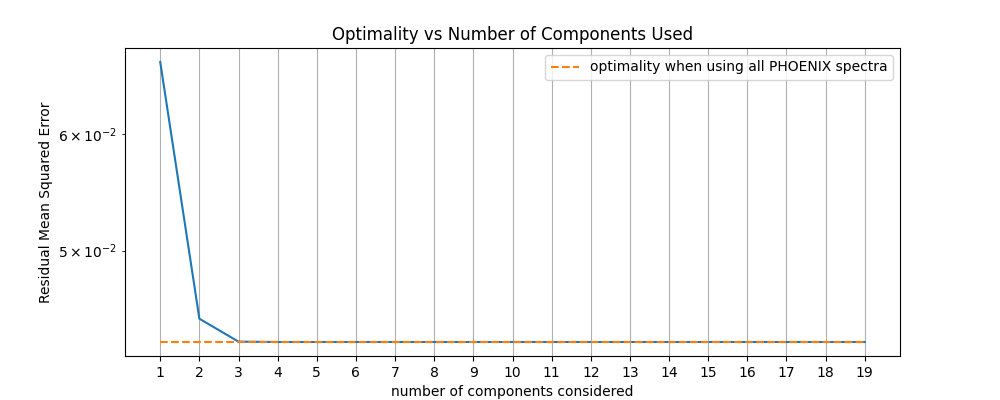

In [6]:
# now lets re-run that, but with only the top few components and see if the fit is better

# prolly want a new class for this
# or could be a list of phoenix spectra; maybe that would help the above code be a bit neater too

ns = np.arange(1, 20, 1)
optimalities = np.array([])

for number_of_components_to_keep in tqdm(ns):
    
    main_components = get_main_components(hash_map, number_of_components_to_keep)

    A_restricted, result_restricted = calc_fitted_spectrum(main_components,
                                                  lookup_table,
                                                  spectrum_to_decompose=spectrum_to_decompose,
                                                  spec_grid = spec_grid,
                                                  mask=mask,
                                                  total_number_of_components=len(main_components),
                                                  verbose=False)

    optimalities = np.append(optimalities, get_optimality(A_restricted, result_restricted, spectrum_to_decompose)[0])

    # _ = plot_nicely(A_restricted, result_restricted, main_components, spec_grid, spectrum_to_decompose)

# plt.clf()
plt.figure(figsize=(10,4))
plt.semilogy(ns, optimalities)
plt.semilogy(ns, [get_optimality(A, result, spectrum_to_decompose)[0]] * len(ns), linestyle="dashed", label="optimality when using all PHOENIX spectra")
plt.xticks(ns)
plt.grid()
plt.legend()
plt.xlabel("number of components considered")
plt.ylabel("Residual Mean Squared Error")  #of matrix minimisation method (lower is more optimal)
plt.title(f"Optimality vs Number of Components Used")
plt.show()

[(<Quantity 4000. K>, <Quantity 0.>, <Quantity 5.>), (<Quantity 3100. K>, <Quantity 1.>, <Quantity 5.>), (<Quantity 2300. K>, <Quantity 0.>, <Quantity 5.>), (<Quantity 3500. K>, <Quantity 0.>, <Quantity 5.>), (<Quantity 3400. K>, <Quantity 0.>, <Quantity 5.>)]
[PHOENIX GRID CREATOR] : phoenix wavelength grid found & loaded in
[PHOENIX GRID CREATOR] : phoenix wavelength grid found & loaded in


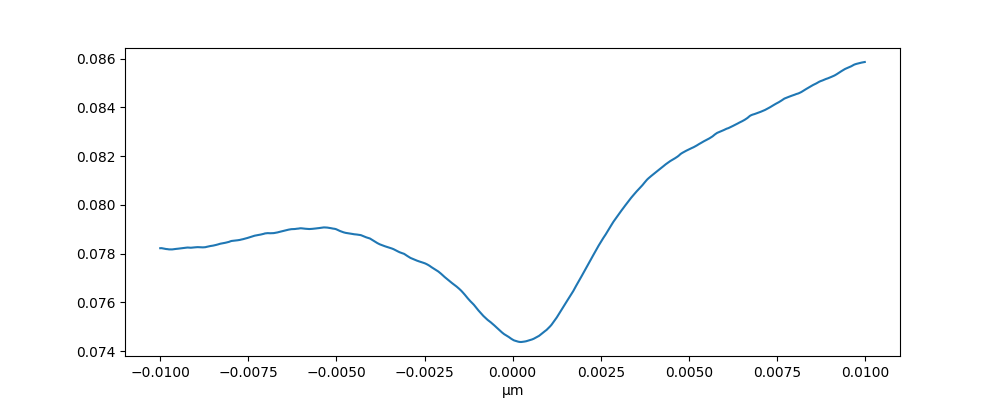

In [ ]:
# now carry out an effectively identical analysis to calibration.py : input some known phoenix spectra, and shift their wavelengths back and forth until the spectra line up. see if this significantly improves things

from matplotlib import pyplot as plt
import numpy as np
from astropy import units as u
from astropy.visualization import quantity_support

quantity_support()

from spectrum_component_analyser.internals.phoenix_spectrum import phoenix_spectrum
from spectrum_component_analyser.internals.readers import JWST_NORMALISING_POINT, JWST_RESOLUTION
from spectrum_component_analyser.internals.spectral_grid import download_spectrum, get_wavelength_grid
from spectrum_component_analyser.internals.spectral_list import spectral_list
from spectrum_component_analyser.internals.spectral_component import spectral_component

number_of_components_to_keep = 5

main_components : list[spectral_component] = get_main_components(hash_map, number_of_components_to_keep)

print([(t, f, l) for t, f, l in main_components])

spec_list : spectral_list = spectral_list.from_internet(
    spectral_components=main_components,
    normalising_point=JWST_NORMALISING_POINT,
    observational_resolution=JWST_RESOLUTION,
    observational_wavelengths=spectrum_to_decompose.Wavelengths,
    name="small spectral grid"
)


























# get wavelength grid and example observational spectrum

phoenix_wavelengths = get_wavelength_grid()

# nearby as in: nearby in parameter space to the observed spectrum
nearby_phoenix_spectrum : phoenix_spectrum = download_spectrum(
    3400 * u.K,
    0.0,
    5.0,
    lte=True,
    alphaM=0,
    phoenix_wavelengths=phoenix_wavelengths,
    normalising_point= JWST_NORMALISING_POINT,
    observational_resolution= JWST_RESOLUTION,
    observational_wavelengths = None,
    name="nearby phoenix spectrum"
)

mask = np.isfinite(spectrum_to_decompose.Fluxes)

roll_resolution = 0.00001 * u.um

def get_MSE(roll : int = 0) -> float:
    # roll to find minimum
    placed_onto_fluxes = np.interp(spectrum_to_decompose.Wavelengths, nearby_phoenix_spectrum.Wavelengths + roll * roll_resolution, nearby_phoenix_spectrum.Fluxes) # new y = np.interp(new x | old x | old y)

    # mask _after_ rolling & interpolating
    # the jwst data always seems to have some NaN; let's remove them
    placed_onto_fluxes = placed_onto_fluxes[mask]

    residual = (placed_onto_fluxes - spectrum_to_decompose[mask].Fluxes) / spectrum_to_decompose[mask].Fluxes
    residual_mean_squared_error = np.sqrt(np.mean(residual**2))

    return residual_mean_squared_error

# how far to move the jwst spectrum to either side to check
max_roll_delta : int = 1000

MSEs = []
rolls = [i for i in reversed(range(-max_roll_delta, max_roll_delta))]

for i in rolls:
    MSEs.append(get_MSE(i))

plt.clf()
plt.cla()
plt.plot(rolls * roll_resolution, MSEs)
plt.show()

# looks to be 0.0042 um off - but fits from main.ipynb suggest moore like 0.0010 (just from eyeing it)